# MonReader

In [1]:
#Load Libraries
import os, sys, random, warnings
from pathlib import Path
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [2]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Directory
dir = "/content/drive/MyDrive/Personal/Apziva/images"

# Setting random state for consistency
seed = 123
np.random.seed(seed)

# Confirm GPU


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Nov 19 02:06:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|          

## Loading and Resizing Photos

In [3]:
# Params
IMG_WIDTH  = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_NOT   = f"{dir}/training/notflip"
TRAIN_FLIP  = f"{dir}/training/flip"
TEST_NOT    = f"{dir}/testing/notflip"
TEST_FLIP   = f"{dir}/testing/flip"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [4]:
def _list_images(p):
    p = Path(p)
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += list(p.rglob(e))   # works whether images are directly inside or nested per-id
    return sorted(files)

def _load_and_resize(path):
    img = imread(str(path))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True, anti_aliasing=True)
    return img.astype(np.uint8)

def load_binary_split():
    # Collect file paths and labels
    train_paths = _list_images(TRAIN_NOT)
    train_labels = [0]*len(train_paths)
    fp = _list_images(TRAIN_FLIP)
    train_paths += fp
    train_labels += [1]*len(fp)

    test_paths  = _list_images(TEST_NOT)
    test_labels = [0]*len(test_paths)
    fp = _list_images(TEST_FLIP)
    test_paths += fp
    test_labels += [1]*len(fp)

    # Shuffle deterministically
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_paths))
    train_paths = [train_paths[i] for i in idx]
    train_labels = np.array([train_labels[i] for i in idx], dtype=np.int32)

    idx = rng.permutation(len(test_paths))
    test_paths = [test_paths[i] for i in idx]
    test_labels = np.array([test_labels[i] for i in idx], dtype=np.int32)

    # Load pixels
    print("Loading and resizing training images...")
    X_train = np.zeros((len(train_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(train_paths)), total=len(train_paths)):
        X_train[i] = _load_and_resize(p)

    print("Loading and resizing test images...")
    X_test = np.zeros((len(test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(test_paths)), total=len(test_paths)):
        X_test[i] = _load_and_resize(p)

    # Scale to [0,1] floats for CNN input
    X_train = (X_train / 255.0).astype(np.float32)
    X_test  = (X_test  / 255.0).astype(np.float32)

    return X_train, train_labels, X_test, test_labels, train_paths, test_paths

X_train, y_train, X_test, y_test, train_files, test_files = load_binary_split()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Loading and resizing training images...


  0%|          | 10/2392 [00:05<20:15,  1.96it/s]


KeyboardInterrupt: 

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


## 2-D CNN Model

In [ ]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(48, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return m

model = build_cnn()

Trial 84 Complete [00h 00m 43s]
val_auc: 0.9727957248687744

Best val_auc So Far: 0.9985173940658569
Total elapsed time: 00h 23m 40s


TypeError: HyperParameters.get() takes 2 positional arguments but 3 were given

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 124, 48)   │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 58, 96)     │       115,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 96)     │       230,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,985 (1.38 MB)

 Trainable params: 361,985 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5116 - auc: 0.4940 - loss: 0.6953 - val_accuracy: 0.4858 - val_auc: 0.5359 - val_loss: 0.6936
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5187 - auc: 0.5329 - loss: 0.6925 - val_accuracy: 0.5360 - val_auc: 0.5841 - val_loss: 0.6824
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5811 - auc: 0.5979 - loss: 0.6705 - val_accuracy: 0.5796 - val_auc: 0.6105 - val_loss: 0.6654
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6014 - auc: 0.6113 - loss: 0.6559 - val_accuracy: 0.6064 - val_auc: 0.6316 - val_loss: 0.6573
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6196 - auc: 0.6267 - loss: 0.6478 - val_accuracy: 0.6097 - val_auc: 0.6534 - val_loss: 0.6568
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6197 - auc: 0.6306 - loss: 0.6470 - val_accuracy: 0.6097 - val_auc: 0.6779 - val_loss: 0.6528
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━

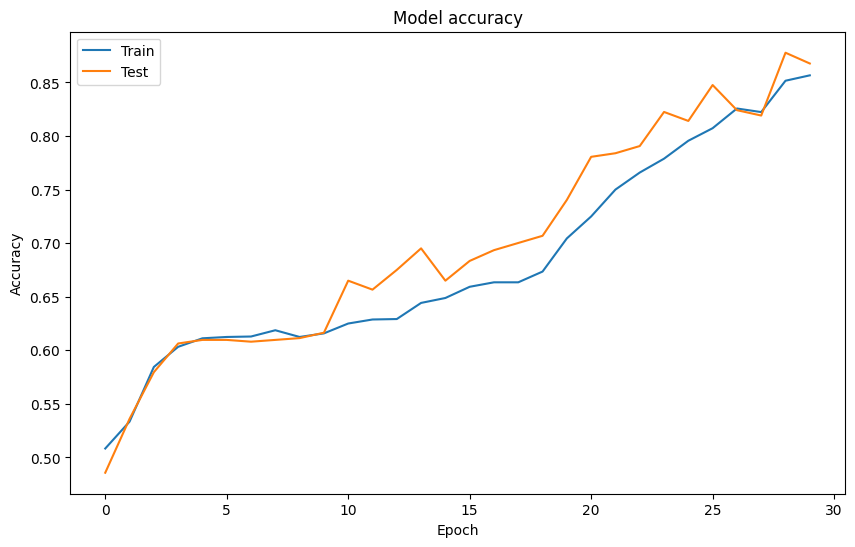

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step


<Figure size 800x600 with 0 Axes>

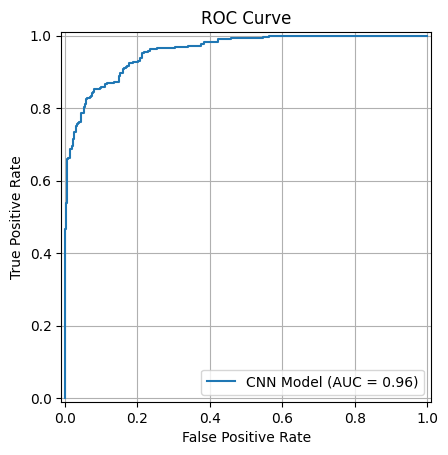

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_keras = model.predict(X_test).ravel()

# Calculate ROC curve and AUC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_keras, tpr=tpr_keras, roc_auc=auc_keras, estimator_name='CNN Model').plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [ ]:
# Calculate F1 Score
# First, convert probabilities to binary predictions (threshold at 0.5)
y_pred_binary = (y_pred_keras > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8668


## Visual Transformer (ViT)

In [3]:
import torch
from transformers import pipeline

pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    dtype=torch.float16,
    device=0
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


In [6]:
import glob
import os # Import os for os.path.join
from pathlib import Path # Keep for consistency with other parts of the notebook if needed, though not directly used in load_paths now

TRAIN_NOT   = f"{dir}/training/notflip"
TRAIN_FLIP  = f"{dir}/training/flip"
TEST_NOT    = f"{dir}/testing/notflip"
TEST_FLIP   = f"{dir}/testing/flip"

def load_paths(pos_dir, neg_dir):
    # Use glob.glob to find files directly in the specified directories
    neg = glob.glob(os.path.join(neg_dir, "*"))
    pos = glob.glob(os.path.join(pos_dir, "*"))

    paths = neg + pos
    labels = [0]*len(neg) + [1]*len(pos)
    return paths, labels

train_files, train_labels = load_paths(TRAIN_FLIP, TRAIN_NOT)
test_files,  test_labels  = load_paths(TEST_FLIP, TEST_NOT)


In [7]:
from datasets import Dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np

model_name = "google/vit-base-patch16-224"

processor = AutoImageProcessor.from_pretrained(model_name)

id2label = {0: "notflip", 1: "flip"}
label2id = {"notflip": 0, "flip": 1}

# Hugging Face Datasets expects dicts
# train_files and test_files are now lists of strings, so no need for str(p) conversion
train_dict = {"image": train_files, "label": train_labels}
test_dict  = {"image": test_files,  "label": test_labels}

train_ds = Dataset.from_dict(train_dict)
test_ds  = Dataset.from_dict(test_dict)

def transform(examples):
    # Load images from paths
    images = [Image.open(p).convert("RGB") for p in examples["image"]]
    inputs = processor(images=images, return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs

train_ds = train_ds.with_transform(transform)
test_ds  = test_ds.with_transform(transform)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # Add this argument to ignore size mismatches in the classification head
)

training_args = TrainingArguments(
    output_dir=f"{dir}/vit-flip-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'